In [1]:
# Import packages
import sqlite3
import pandas as pd
import numpy as np
import os

In [2]:
# Config
DB_PATH = "cfb_data.db"
PRE_GAME_ELO_CSV_PATH = 'games_with_pregame_elo.csv'

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Define the path to your desired directory in Google Drive
drive_path = '/content/drive/MyDrive/Betting/BettingModels'

# Change the current working directory to the desired location
os.chdir(drive_path)

# Verify the current working directory (optional)
print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Betting/BettingModels


# Phase 1: Data Foundation and Feature Engineering

## Step 1: Data Consolidation

In [4]:
print(f"Connecting to database: {DB_PATH}")
conn = sqlite3.connect(DB_PATH)

# Load games_full data - Select ALL potentially relevant columns
# Explicitly listing columns is generally better than SELECT *
# Make sure this list matches the columns in your 'games_full' table
# (Derived from your initial dataset_head.csv)
all_feature_columns = [
    'id', 'season', 'week', 'season_type', 'completed', 'neutral_site',
    'conference_game', 'attendance', 'home_team', 'home_conference',
    'home_division', 'home_points', 'home_post_win_prob', 'home_pregame_elo', # Note: We use our CALC'd elo later
    'home_postgame_elo', 'away_team', 'away_conference', 'away_division',
    'away_points', 'away_post_win_prob', 'away_pregame_elo', # Note: We use our CALC'd elo later
    'away_postgame_elo', 'avg_closing_spread', 'avg_closing_total',
    'avg_opening_spread', 'avg_opening_total',
    # Home Offense Stats
    'home_offense_plays', 'home_offense_drives', 'home_offense_ppa',
    'home_offense_totalPPA', 'home_offense_successRate', 'home_offense_explosiveness',
    'home_offense_powerSuccess', 'home_offense_stuffRate', 'home_offense_lineYards',
    'home_offense_lineYardsTotal', 'home_offense_secondLevelYards',
    'home_offense_secondLevelYardsTotal', 'home_offense_openFieldYards',
    'home_offense_openFieldYardsTotal', 'home_offense_standardDowns_ppa',
    'home_offense_standardDowns_successRate', 'home_offense_standardDowns_explosiveness',
    'home_offense_passingDowns_ppa', 'home_offense_passingDowns_successRate',
    'home_offense_passingDowns_explosiveness', 'home_offense_rushingPlays_ppa',
    'home_offense_rushingPlays_totalPPA', 'home_offense_rushingPlays_successRate',
    'home_offense_rushingPlays_explosiveness', 'home_offense_passingPlays_ppa',
    'home_offense_passingPlays_totalPPA', 'home_offense_passingPlays_successRate',
    'home_offense_passingPlays_explosiveness',
    # Home Defense Stats
    'home_defense_plays', 'home_defense_drives', 'home_defense_ppa',
    'home_defense_totalPPA', 'home_defense_successRate', 'home_defense_explosiveness',
    'home_defense_powerSuccess', 'home_defense_stuffRate', 'home_defense_lineYards',
    'home_defense_lineYardsTotal', 'home_defense_secondLevelYards',
    'home_defense_secondLevelYardsTotal', 'home_defense_openFieldYards',
    'home_defense_openFieldYardsTotal', 'home_defense_standardDowns_ppa',
    'home_defense_standardDowns_successRate', 'home_defense_standardDowns_explosiveness',
    'home_defense_passingDowns_ppa', 'home_defense_passingDowns_successRate',
    'home_defense_passingDowns_explosiveness', 'home_defense_rushingPlays_ppa',
    'home_defense_rushingPlays_totalPPA', 'home_defense_rushingPlays_successRate',
    'home_defense_rushingPlays_explosiveness', 'home_defense_passingPlays_ppa',
    'home_defense_passingPlays_totalPPA', 'home_defense_passingPlays_successRate',
    'home_defense_passingPlays_explosiveness',
    # Away Offense Stats (matches home offense structure)
    'away_offense_plays', 'away_offense_drives', 'away_offense_ppa',
    'away_offense_totalPPA', 'away_offense_successRate', 'away_offense_explosiveness',
    'away_offense_powerSuccess', 'away_offense_stuffRate', 'away_offense_lineYards',
    'away_offense_lineYardsTotal', 'away_offense_secondLevelYards',
    'away_offense_secondLevelYardsTotal', 'away_offense_openFieldYards',
    'away_offense_openFieldYardsTotal', 'away_offense_standardDowns_ppa',
    'away_offense_standardDowns_successRate', 'away_offense_standardDowns_explosiveness',
    'away_offense_passingDowns_ppa', 'away_offense_passingDowns_successRate',
    'away_offense_passingDowns_explosiveness', 'away_offense_rushingPlays_ppa',
    'away_offense_rushingPlays_totalPPA', 'away_offense_rushingPlays_successRate',
    'away_offense_rushingPlays_explosiveness', 'away_offense_passingPlays_ppa',
    'away_offense_passingPlays_totalPPA', 'away_offense_passingPlays_successRate',
    'away_offense_passingPlays_explosiveness',
    # Away Defense Stats (matches home defense structure)
    'away_defense_plays', 'away_defense_drives', 'away_defense_ppa',
    'away_defense_totalPPA', 'away_defense_successRate', 'away_defense_explosiveness',
    'away_defense_powerSuccess', 'away_defense_stuffRate', 'away_defense_lineYards',
    'away_defense_lineYardsTotal', 'away_defense_secondLevelYards',
    'away_defense_secondLevelYardsTotal', 'away_defense_openFieldYards',
    'away_defense_openFieldYardsTotal', 'away_defense_standardDowns_ppa',
    'away_defense_standardDowns_successRate', 'away_defense_standardDowns_explosiveness',
    'away_defense_passingDowns_ppa', 'away_defense_passingDowns_successRate',
    'away_defense_passingDowns_explosiveness', 'away_defense_rushingPlays_ppa',
    'away_defense_rushingPlays_totalPPA', 'away_defense_rushingPlays_successRate',
    'away_defense_rushingPlays_explosiveness', 'away_defense_passingPlays_ppa',
    'away_defense_passingPlays_totalPPA', 'away_defense_passingPlays_successRate',
    'away_defense_passingPlays_explosiveness',
    # Other stats
    'home_turnovers', 'home_possessionTime', 'away_turnovers', 'away_possessionTime'
]

# Construct the SQL query string dynamically
select_clause = ",\n    ".join([f"g.{col}" for col in all_feature_columns])
games_query = f"""
SELECT
    {select_clause}
FROM
    games_full g
WHERE
    g.completed = 1 -- Only use completed games
ORDER BY
    g.season, g.week, g.id;
"""
# print(games_query) # Optional: Print the generated query to verify

print("Loading ALL games data (including advanced stats)...")
games_df = pd.read_sql_query(games_query, conn)
print(f"Loaded {len(games_df)} completed games with {len(games_df.columns)} columns.")
conn.close()

Connecting to database: cfb_data.db
Loading ALL games data (including advanced stats)...
Loaded 9816 completed games with 142 columns.


### Pre-processing Games Data

In [5]:
# Convert boolean-like columns to integers (0 or 1) for models
games_df['neutral_site'] = games_df['neutral_site'].astype(int)
games_df['conference_game'] = games_df['conference_game'].astype(int)

# Convert spread/total/score columns to numeric, coercing errors to NaN
numeric_cols = ['avg_closing_spread', 'avg_closing_total', 'avg_opening_spread',
                'avg_opening_total', 'home_points', 'away_points',
                'attendance', 'home_possessionTime', 'away_possessionTime',
                # Add Elo/win prob if needed, though we'll use our own Elo primarily
                'home_post_win_prob', 'home_pregame_elo', 'home_postgame_elo',
                'away_post_win_prob', 'away_pregame_elo', 'away_postgame_elo']

# Convert all advanced stat columns to numeric
# Identify the first advanced stat column to loop from there
first_adv_stat_col = 'home_offense_plays'
first_adv_stat_idx = games_df.columns.get_loc(first_adv_stat_col)
adv_stat_cols = games_df.columns[first_adv_stat_idx:]

numeric_cols.extend(adv_stat_cols)

print("Converting relevant columns to numeric...")
for col in numeric_cols:
    if col in games_df.columns: # Check if column exists (robustness)
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')

# Report missing values for key targets/inputs after conversion
check_missing_cols = ['avg_closing_spread', 'home_points', 'away_points']
print("Missing value check (post-numeric conversion):")
for col in check_missing_cols:
     if col in games_df.columns:
        missing_pct = games_df[col].isnull().mean() * 100
        print(f"  Column '{col}' missing: {missing_pct:.2f}%")

# Drop rows where essential score data might be missing after conversion
games_df.dropna(subset=['home_points', 'away_points'], inplace=True)

Converting relevant columns to numeric...
Missing value check (post-numeric conversion):
  Column 'avg_closing_spread' missing: 0.95%
  Column 'home_points' missing: 0.00%
  Column 'away_points' missing: 0.00%


### Load Pre-Calculated Elo Ratings

In [6]:
print(f"Loading pre-game Elo ratings from: {PRE_GAME_ELO_CSV_PATH}")
pre_game_elo_df = pd.read_csv(PRE_GAME_ELO_CSV_PATH)
pre_game_elo_df = pre_game_elo_df[['game_id', 'home_pregame_elo', 'away_pregame_elo']]
print(f"Loaded Elo ratings for {len(pre_game_elo_df)} games.")

# Rename columns to avoid conflict with original Elo cols and clarify source
pre_game_elo_df.rename(columns={
    'home_pregame_elo': 'home_pregame_elo_calc',
    'away_pregame_elo': 'away_pregame_elo_calc'
}, inplace=True)

Loading pre-game Elo ratings from: games_with_pregame_elo.csv
Loaded Elo ratings for 9816 games.


### Merge Games and Elo Data

In [7]:
print("Merging games data with pre-game Elo ratings...")
master_df = pd.merge(
    games_df,
    pre_game_elo_df,
    left_on='id',
    right_on='game_id',
    how='left'
)

# Check for games potentially missed by the merge
missing_elo_count = master_df['home_pregame_elo_calc'].isnull().sum()
if missing_elo_count > 0:
    print(f"Warning: {missing_elo_count} games are missing calculated pre-game Elo ratings after merge.")
    # Depending on strategy, might drop these rows later if calc'd Elo is crucial
    # master_df.dropna(subset=['home_pregame_elo_calc', 'away_pregame_elo_calc'], inplace=True)

master_df.drop(columns=['game_id'], inplace=True)

Merging games data with pre-game Elo ratings...


### Critical: Drop Target Variable Missing Data and Sort Chronologically

In [8]:
print("Sorting final DataFrame chronologically...")
master_df.sort_values(by=['season', 'week', 'id'], inplace=True)
master_df.reset_index(drop=True, inplace=True)

Sorting final DataFrame chronologically...


### Inspect Consolidated Data

In [9]:
print("\n--- Master DataFrame Info (Now includes all stats) ---")
master_df.info() # Will show many more columns now

# Displaying head/tail might be too wide, focus on key columns
print("\n--- Master DataFrame Head (Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].head())

print("\n--- Master DataFrame Tail (Check Sorting - Key Columns) ---")
print(master_df[['id', 'season', 'week', 'home_team', 'away_team',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].tail())


--- Master DataFrame Info (Now includes all stats) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Columns: 144 entries, id to away_pregame_elo_calc
dtypes: float64(131), int64(6), object(7)
memory usage: 10.8+ MB

--- Master DataFrame Head (Key Columns) ---
          id  season  week       home_team         away_team  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   avg_closing_spread  avg_opening_spread  home_pregame_elo_calc  \
0          -41.000000                 NaN                 1500.0   
1          -33.000000                 NaN                 1500.0   
2          -20.000000                 NaN                 1500.0   
3           22.833333                 NaN            

## Step 2: Definte Target Variable & Basic Features

In [10]:
# Define the primary target variable
target_variable = 'avg_closing_spread'
print(f"\nTarget Variable: '{target_variable}'")

# Check target missing values
target_missing_pct = master_df[target_variable].isnull().mean() * 100
print(f"Missing values in target ('{target_variable}'): {target_missing_pct:.2f}%")

# Drop rows where the target variable is NaN
master_df.dropna(subset=[target_variable], inplace=True)
master_df.reset_index(drop=True, inplace=True)

# Verify the target column now has no NaNs
print(f"Missing values in target after dropping: {master_df[target_variable].isnull().sum()}")

# Define initial, basic features (using our CALCULATED Elo)
# Note: We exclude the original home/away_pregame_elo from the DB unless needed for comparison
basic_features = [
    'home_pregame_elo_calc', # Our calculated Elo
    'away_pregame_elo_calc', # Our calculated Elo
    'neutral_site',
    'conference_game',
    'season',
    'week'
]
# Engineer Elo difference feature using our calculated Elo
master_df['elo_diff_calc'] = master_df['home_pregame_elo_calc'] - master_df['away_pregame_elo_calc']
basic_features.append('elo_diff_calc')

print(f"\nBasic Features Selected ({len(basic_features)}):")
print(basic_features)

# Display the target and basic features for a few rows
print("\n--- Target and Basic Features (Head) ---")
# Handle potential missing calculated Elo values if not dropped earlier
print(master_df[[target_variable] + basic_features].head())


Target Variable: 'avg_closing_spread'
Missing values in target ('avg_closing_spread'): 0.95%
Missing values in target after dropping: 0

Basic Features Selected (7):
['home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutral_site', 'conference_game', 'season', 'week', 'elo_diff_calc']

--- Target and Basic Features (Head) ---
   avg_closing_spread  home_pregame_elo_calc  away_pregame_elo_calc  \
0          -41.000000                 1500.0                 1200.0   
1          -33.000000                 1500.0                 1200.0   
2          -20.000000                 1500.0                 1200.0   
3           22.833333                 1500.0                 1500.0   
4          -30.500000                 1500.0                 1200.0   

   neutral_site  conference_game  season  week  elo_diff_calc  
0             1                0    2013     1          300.0  
1             0                0    2013     1          300.0  
2             0                0    2013     1     

## Step 3 Advanced Stat Feature Engineering

### Identify Stats for Rolling Averages

In [11]:
# Select key efficiency/explosiveness metrics. Start with a focused list.
# Expand this list later if needed.
stats_to_roll = [
    # Overall Offense
    'offense_ppa',
    'offense_successRate',
    'offense_explosiveness',
    # Rushing Offense
    'offense_rushingPlays_ppa',
    'offense_rushingPlays_successRate',
    'offense_rushingPlays_explosiveness',
    'offense_lineYards', # Potentially useful offensive line proxy
    # Passing Offense
    'offense_passingPlays_ppa',
    'offense_passingPlays_successRate',
    'offense_passingPlays_explosiveness',
    # Standard Downs
    'offense_standardDowns_ppa',
    'offense_standardDowns_successRate',
    'offense_standardDowns_explosiveness',
    # Passing Downs
    'offense_passingDowns_ppa',
    'offense_passingDowns_successRate',
    'offense_passingDowns_explosiveness',
    # Overall Defense (using opponent's offensive stats)
    'defense_ppa',
    'defense_successRate',
    'defense_explosiveness',
    # Rushing Defense
    'defense_rushingPlays_ppa',
    'defense_rushingPlays_successRate',
    'defense_rushingPlays_explosiveness',
    'defense_lineYards', # Potentially useful defensive line proxy
    # Passing Defense
    'defense_passingPlays_ppa',
    'defense_passingPlays_successRate',
    'defense_passingPlays_explosiveness',
    # Standard Downs
    'defense_standardDowns_ppa',
    'defense_standardDowns_successRate',
    'defense_standardDowns_explosiveness',
    # Passing Downs
    'defense_passingDowns_ppa',
    'defense_passingDowns_successRate',
    'defense_passingDowns_explosiveness',
    # Special Teams / Other (Add if desired, e.g., avg starting field position - needs raw data)
    'turnovers' # Average turnovers forced/committed
]

# Define EWMA span (adjust as needed, smaller span = more weight on recent)
# A span of 5 roughly means the last ~5 games have the most influence.
ewma_span = 5
min_periods_for_ewma = max(1, ewma_span // 2) # Start calculating EWMA after a few games

print(f"Selected {len(stats_to_roll)} stats for EWMA (span={ewma_span}).")

Selected 33 stats for EWMA (span=5).


### Reshape Data to Team-Centric Format

In [12]:
# Create two temporary dataframes, one for home team stats, one for away
home_stats = master_df[['id', 'season', 'week', 'home_team', 'away_team']].copy()
away_stats = master_df[['id', 'season', 'week', 'away_team', 'home_team']].copy()

home_stats.rename(columns={'home_team': 'team', 'away_team': 'opponent'}, inplace=True)
away_stats.rename(columns={'away_team': 'team', 'home_team': 'opponent'}, inplace=True)

# Add actual stats, renaming columns to generic 'offense_*', 'defense_*'
print("Reshaping data to team-centric format...")
for stat_base in stats_to_roll:
    # Determine if it's an offense or defense stat based on original column name structure
    # This requires stats_to_roll names to match the generic part after home_/away_
    home_col = f'home_{stat_base}'
    away_col = f'away_{stat_base}'

    if home_col in master_df.columns and away_col in master_df.columns and stat_base != 'turnovers':
        # Offensive and Defensive stat for the teams
        home_stats[stat_base] = master_df[home_col]
        away_stats[stat_base] = master_df[away_col]

    # Handle turnovers specifically if included
    elif stat_base == 'turnovers':
      home_stats['turnovers_committed'] = master_df['home_turnovers']
      home_stats['turnovers_forced'] = master_df['away_turnovers'] # Home defense forced away turnovers
      away_stats['turnovers_committed'] = master_df['away_turnovers']
      away_stats['turnovers_forced'] = master_df['home_turnovers'] # Away defense forced home turnovers


# Combine home and away views
team_game_df = pd.concat([home_stats, away_stats], ignore_index=True)

Reshaping data to team-centric format...


In [13]:
team_game_df[(team_game_df['season'] == 2024) & (team_game_df['team'] == 'Alabama')]

,id,season,week,team,opponent,offense_ppa,offense_successRate,offense_explosiveness,offense_rushingPlays_ppa,offense_rushingPlays_successRate,...,defense_passingPlays_successRate,defense_passingPlays_explosiveness,defense_standardDowns_ppa,defense_standardDowns_successRate,defense_standardDowns_explosiveness,defense_passingDowns_ppa,defense_passingDowns_successRate,defense_passingDowns_explosiveness,turnovers_committed,turnovers_forced
8865,401628319,2024,1,Alabama,Western Kentucky,1.343144,0.476190,3.393672,0.848881,0.400000,...,0.218750,1.626537,-0.334946,0.208333,0.993355,-0.111976,0.208333,1.774230,1.0,2.0
8950,401628335,2024,2,Alabama,South Florida,0.262745,0.402985,1.324513,0.222252,0.421053,...,0.230769,1.054071,-0.084724,0.375000,0.799680,-0.018798,0.153846,2.022206,3.0,0.0
9156,401628374,2024,5,Alabama,Georgia,0.294012,0.471429,1.415743,0.088653,0.303030,...,0.411765,1.863592,0.301670,0.500000,1.671896,0.199035,0.296296,1.396293,1.0,4.0
9259,401628385,2024,7,Alabama,South Carolina,0.139325,0.491803,1.116730,0.177998,0.558824,...,0.428571,1.765896,-0.021626,0.450980,0.847218,0.647312,0.400000,2.744422,2.0,4.0
9370,401628400,2024,9,Alabama,Missouri,0.242476,0.442308,1.183641,0.246868,0.480000,...,0.166667,0.819375,-0.238444,0.411765,0.623779,-0.290358,0.076923,1.885113,0.0,3.0
9532,401628425,2024,12,Alabama,Mercer,0.614156,0.567568,1.514592,0.559102,0.571429,...,0.466667,1.237692,-0.493196,0.363636,1.004340,-0.073049,0.400000,1.198271,0.0,3.0
9646,401628437,2024,14,Alabama,Auburn,0.166806,0.487179,1.011816,0.004522,0.425926,...,0.395349,1.489217,-0.015114,0.454545,0.938314,0.426650,0.333333,1.985699,4.0,2.0
18751,401628350,2024,3,Alabama,Wisconsin,0.558540,0.487179,1.560085,0.512140,0.500000,...,0.357143,1.559695,-0.000990,0.465116,0.890309,0.346370,0.375000,1.360695,0.0,2.0
18938,401628384,2024,6,Alabama,Vanderbilt,0.464147,0.555556,1.499859,0.388686,0.473684,...,0.666667,2.091545,0.057245,0.420000,1.052493,0.639085,0.416667,2.228449,2.0,0.0
19039,401628397,2024,8,Alabama,Tennessee,-0.066958,0.363636,1.040095,-0.068640,0.400000,...,0.343750,2.318390,-0.190941,0.382979,0.738230,0.462074,0.307692,2.615161,2.0,3.0


### Critical: Sort for Rolling Calculation

In [14]:
print("Sorting team-centric data...")
team_game_df.sort_values(by=['team', 'season', 'week', 'id'], inplace=True)

Sorting team-centric data...


### Calculate Lagged EWMA

In [15]:
print(f"Calculating lagged EWMAs (span={ewma_span})...")
ewma_cols_generated = []
stats_to_roll.append('turnovers_committed')
stats_to_roll.append('turnovers_forced')
stats_to_roll.remove('turnovers')
for stat in stats_to_roll:
    if stat in team_game_df.columns: # Ensure stat column was created successfully
        ewma_col_name = f'{stat}_ewma_lag1'
        # Calculate EWMA and shift within each group
        # Use transform for efficiency if possible
        team_game_df[ewma_col_name] = team_game_df.groupby('team')[stat].transform(
            lambda x: x.ewm(span=ewma_span, min_periods=min_periods_for_ewma, adjust=True).mean().shift(1)
        )
        ewma_cols_generated.append(ewma_col_name)
    else:
        print(f"Skipping EWMA for '{stat}' as column not found in team_game_df.")

print(f"Generated {len(ewma_cols_generated)} EWMA columns.")

Calculating lagged EWMAs (span=5)...
Generated 34 EWMA columns.


### Merge back to Master DataFrame

In [16]:
print("Merging EWMA features back to master DataFrame...")

# Select only necessary columns from team_game_df for merging
ewma_features_to_merge = team_game_df[['id', 'team'] + ewma_cols_generated].copy()

# Merge for Home Team stats
master_df_merged = pd.merge(
    master_df,
    ewma_features_to_merge,
    left_on=['id', 'home_team'],
    right_on=['id', 'team'],
    how='left',
    suffixes=('', '_y') # Avoid suffix collision initially
)
# Rename merged columns for home team
home_ewma_rename_dict = {col: f'home_{col}' for col in ewma_cols_generated}
master_df_merged.rename(columns=home_ewma_rename_dict, inplace=True)
master_df_merged.drop(columns=['team'], inplace=True) # Drop the 'team' column from the merge

# Merge for Away Team stats
master_df_final = pd.merge(
    master_df_merged,
    ewma_features_to_merge,
    left_on=['id', 'away_team'],
    right_on=['id', 'team'],
    how='left',
    suffixes=('', '_y') # Avoid suffix collision
)
# Rename merged columns for away team
away_ewma_rename_dict = {col: f'away_{col}' for col in ewma_cols_generated}
master_df_final.rename(columns=away_ewma_rename_dict, inplace=True)
master_df_final.drop(columns=['team'], inplace=True) # Drop the 'team' column from the merge

# Clean up any potential duplicate '_y' columns if merging caused issues (shouldn't with suffixes)
cols_to_drop = [col for col in master_df_final.columns if col.endswith('_y')]
if cols_to_drop:
    print(f"Dropping potentially duplicated columns: {cols_to_drop}")
    master_df_final.drop(columns=cols_to_drop, inplace=True)

Merging EWMA features back to master DataFrame...


**Note: When we have FBS vs. FCS games, all of our shifted EWM data for the FCS team is very likely to be NaN because we don't have previous games**

### Create Matchup Features

In [17]:
print("Creating matchup features (differences)...")
matchup_features = []

# Examples: Home Offense vs Away Defense
for stat in stats_to_roll:
    if stat.startswith('offense_'): # e.g., offense_ppa
        def_equiv_stat = stat.replace('offense_', 'defense_') # e.g., defense_ppa
        home_off_col = f'home_{stat}_ewma_lag1'
        away_def_col = f'away_{def_equiv_stat}_ewma_lag1'
        if home_off_col in master_df_final.columns and away_def_col in master_df_final.columns:
            matchup_col_name = f'matchup_HO_v_AD_{stat.replace("offense_", "")}_ewma_lag1'
            master_df_final[matchup_col_name] = master_df_final[home_off_col] - master_df_final[away_def_col]
            matchup_features.append(matchup_col_name)

# Examples: Away Offense vs Home Defense
for stat in stats_to_roll:
     if stat.startswith('offense_'): # e.g., offense_ppa
        def_equiv_stat = stat.replace('offense_', 'defense_') # e.g., defense_ppa
        away_off_col = f'away_{stat}_ewma_lag1'
        home_def_col = f'home_{def_equiv_stat}_ewma_lag1'
        if away_off_col in master_df_final.columns and home_def_col in master_df_final.columns:
            matchup_col_name = f'matchup_AO_v_HD_{stat.replace("offense_", "")}'
            master_df_final[matchup_col_name] = master_df_final[away_off_col] - master_df_final[home_def_col]
            matchup_features.append(matchup_col_name)


print(f"Generated {len(matchup_features)} matchup difference features.")

Creating matchup features (differences)...
Generated 32 matchup difference features.


### Update Master Dataframe

In [18]:
master_df = master_df_final # Replace the old master_df
del master_df_merged, master_df_final, team_game_df, home_stats, away_stats # Clean up memory

### Inspect Engineered Features

In [19]:
print("\n--- Inspecting Engineered Features (Head) ---")
engineered_feature_cols = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
print(master_df[['id', 'season', 'week', 'home_team', 'away_team'] + engineered_feature_cols].head())

# Check for NaNs introduced by lagging/EWMA (expected early season)
print("\n--- NaN check for first few EWMA features ---")
missing_pcts = []
for col in engineered_feature_cols: # Check first few
    missing_pct = master_df[col].isnull().mean() * 100
    missing_pcts.append(missing_pct)
    print(f"  Feature '{col}' missing: {missing_pct:.2f}%")


--- Inspecting Engineered Features (Head) ---
          id  season  week       home_team         away_team  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   home_offense_ppa_ewma_lag1  home_offense_successRate_ewma_lag1  \
0                         NaN                                 NaN   
1                         NaN                                 NaN   
2                         NaN                                 NaN   
3                         NaN                                 NaN   
4                         NaN                                 NaN   

   home_offense_explosiveness_ewma_lag1  \
0                                   NaN   
1                                   NaN   
2                       

### Definte Final Feature List (Example)

In [20]:
# Combine basic features with the new engineered features
# We might refine this later in feature selection
all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
potential_features = basic_features + all_engineered_features
print(f"\nTotal potential features generated: {len(potential_features)}")
# print("Potential Features:", potential_features) # Uncomment to see full list

print("\n--- Phase 1, Step 3 Complete ---")
print("Engineered features (lagged EWMAs, matchups) added.")
print("Next Steps: Handling Missing Values in Features, Feature Selection.")


Total potential features generated: 107

--- Phase 1, Step 3 Complete ---
Engineered features (lagged EWMAs, matchups) added.
Next Steps: Handling Missing Values in Features, Feature Selection.


## Step 4: Handling Missing Data

### Indentify and Quantify Missing Feature Values

In [21]:
# Use the 'potential_features' list created at the end of Step 3
# If you didn't create it, define it again:
# all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
# potential_features = basic_features + all_engineered_features # basic_features defined in step 2

# Calculate missing percentage for features we might use
print(f"Checking missing values for {len(potential_features)} potential features...")
missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0] # Filter to only show columns with missing data

print("\nFeatures with Missing Values (%):")
if missing_summary.empty:
    print("No missing values found in the potential feature set.")
else:
    with pd.option_context('display.max_rows', None): # Ensure all rows are printed
        print(missing_summary)

Checking missing values for 107 potential features...

Features with Missing Values (%):
matchup_AO_v_HD_passingDowns_explosiveness               3.671706
away_offense_passingDowns_explosiveness_ewma_lag1        3.558572
matchup_AO_v_HD_rushingPlays_explosiveness               3.517433
matchup_AO_v_HD_passingPlays_explosiveness               3.507148
matchup_HO_v_AD_passingDowns_explosiveness_ewma_lag1     3.486578
matchup_AO_v_HD_standardDowns_explosiveness              3.476293
matchup_HO_v_AD_rushingPlays_explosiveness_ewma_lag1     3.466008
matchup_HO_v_AD_passingPlays_explosiveness_ewma_lag1     3.466008
matchup_AO_v_HD_explosiveness                            3.466008
matchup_HO_v_AD_standardDowns_explosiveness_ewma_lag1    3.455724
matchup_HO_v_AD_rushingPlays_ppa_ewma_lag1               3.455724
matchup_HO_v_AD_passingDowns_successRate_ewma_lag1       3.445439
matchup_HO_v_AD_passingDowns_ppa_ewma_lag1               3.445439
matchup_HO_v_AD_standardDowns_ppa_ewma_lag1          

### Decide on Imputation Strategy

Option A: Let Model Handle (XGBoost/LightGBM) -- Chosen for Now

* These models can often learn optimal imputation strategy internally
* PROS: Simple, potentially optimal performance
* CONS: Requires model that supports it.

Option B: Mean/Median Imputation:


*   Replace NaN with mean/median calculated ONLY from the training set
*   PROS: Works for any model
*   CONS: Distorts feature distribution, leaks info if mean/median calculated globally

Option C: Zero Imputation
* Replace NaN with 0
* PROS: Simple
* CONS: Often inappropriate for rates/averages, changes feature meaning.



### Implement Strategy

In [22]:
# If we were doing Option B (Mean Imputation - Incorrect Global Example for Demo):
# print("\n--- Example: Global Mean Imputation (NOT RECOMMENDED - DATA LEAKAGE) ---")
# features_to_impute = missing_summary.index.tolist() # Columns identified with NaNs
# for col in features_to_impute:
#    mean_val = master_df[col].mean() # GLOBAL mean - incorrect for proper validation
#    master_df[col].fillna(mean_val, inplace=True)
#    print(f"Imputed '{col}' with global mean: {mean_val:.4f}")
# print("--- End Example ---")

### Verify

In [23]:
print("\nVerifying NaN status (Option A - NaNs should remain):")
remaining_missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
remaining_missing_summary = remaining_missing_summary[remaining_missing_summary > 0]

if remaining_missing_summary.empty:
    print("No missing values remain in potential features (unexpected for Option A).")
elif not remaining_missing_summary.equals(missing_summary):
     print("Missing values changed unexpectedly without imputation.")
     print("\nRemaining Features with Missing Values (%):")
     with pd.option_context('display.max_rows', None):
        print(remaining_missing_summary)
else:
    print("NaN values remain in features as expected for Strategy A.")
    print(f"Top 5 features with most NaNs:\n{remaining_missing_summary.head()}")


print("\n--- Phase 1, Step 4 Complete ---")
print("Missing data identified and strategy chosen (defer imputation for tree models).")
print("Next Steps: Feature Selection.")


Verifying NaN status (Option A - NaNs should remain):
NaN values remain in features as expected for Strategy A.
Top 5 features with most NaNs:
matchup_AO_v_HD_passingDowns_explosiveness              3.671706
away_offense_passingDowns_explosiveness_ewma_lag1       3.558572
matchup_AO_v_HD_rushingPlays_explosiveness              3.517433
matchup_AO_v_HD_passingPlays_explosiveness              3.507148
matchup_HO_v_AD_passingDowns_explosiveness_ewma_lag1    3.486578
dtype: float64

--- Phase 1, Step 4 Complete ---
Missing data identified and strategy chosen (defer imputation for tree models).
Next Steps: Feature Selection.


# Phase 2: Feature Selection and Training

In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split # We'll use this for structure, but split chronologically
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Selection

## Step 0: Preparation - Temporal Split

In [25]:
# Define split points (adjust seasons as needed based on your data range)
# Example: Train through 2020, Validate on 2021-2022, Test on 2023+
TRAIN_END_SEASON = 2020
VALIDATION_END_SEASON = 2022
# TEST_START_SEASON = VALIDATION_END_SEASON + 1

print(f"Splitting data chronologically:")
print(f"  Training:   Seasons <= {TRAIN_END_SEASON}")
print(f"  Validation: Seasons > {TRAIN_END_SEASON} and <= {VALIDATION_END_SEASON}")
# print(f"  Test:       Seasons > {VALIDATION_END_SEASON}") # Test set held out

Splitting data chronologically:
  Training:   Seasons <= 2020
  Validation: Seasons > 2020 and <= 2022


In [26]:
train_df = master_df[master_df['season'] <= TRAIN_END_SEASON].copy()
val_df = master_df[(master_df['season'] > TRAIN_END_SEASON) &
                   (master_df['season'] <= VALIDATION_END_SEASON)].copy()
# test_df = master_df[master_df['season'] >= TEST_START_SEASON].copy() # Keep this commented out for now

print(f"\nData Shapes:")
print(f"  Training Set:   {train_df.shape}")
print(f"  Validation Set: {val_df.shape}")
# print(f"  Test Set:       {test_df.shape}")

# Define Feature Set (use the list from end of Phase 1)
# If not defined earlier, recreate it:
basic_features = [col for col in master_df.columns if col in ['neutral_site', 'conference_game', 'season', 'week', 'home_pregame_elo_calc','away_pregame_elo_calc','elo_diff_calc']]
all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
potential_features = basic_features + all_engineered_features
print("Recreated potential_features list.")

# Separate features (X) and target (y) for each set
y_train = train_df[target_variable]
X_train = train_df[potential_features].copy() # Use .copy() to avoid SettingWithCopyWarning

y_val = val_df[target_variable]
X_val = val_df[potential_features].copy()

# y_test = test_df[target_variable]
# X_test = test_df[potential_features].copy()

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
# print(f"  X_test:  {X_test.shape}")



Data Shapes:
  Training Set:   (6301, 245)
  Validation Set: (1699, 245)
Recreated potential_features list.

Feature matrix shapes:
  X_train: (6301, 107)
  X_val:   (1699, 107)


In [27]:
# --- Handling NaNs Temporarily for Selection Analysis ---
# VarianceThreshold and .corr() don't handle NaNs well.
# We'll impute with the MEDIAN calculated *only from the training set*
# This is TEMPORARY for analysis; the final model might handle NaNs differently.
print("\nTemporarily imputing NaNs with training set median for selection analysis...")
features_with_nan = X_train.columns[X_train.isnull().any()].tolist()
imputation_values = X_train[features_with_nan].median()

X_train.fillna(imputation_values, inplace=True)
# Apply the SAME imputation values calculated from training data to validation set
X_val.fillna(imputation_values, inplace=True)
# X_test.fillna(imputation_values, inplace=True) # Impute test set later

print(f"Imputed {len(features_with_nan)} columns.")
print(f"NaN check after imputation (X_train): {X_train.isnull().sum().sum()}") # Should be 0
print(f"NaN check after imputation (X_val):   {X_val.isnull().sum().sum()}")   # Should be 0


Temporarily imputing NaNs with training set median for selection analysis...
Imputed 100 columns.
NaN check after imputation (X_train): 0
NaN check after imputation (X_val):   0


## Step 1: Initial Filtering

In [28]:
# --- 1a: Low Variance Feature Removal ---
print("\n--- Filtering: Low Variance Features ---")
variance_threshold = 0.005 # Remove features with variance below this (tweak if needed)
selector_var = VarianceThreshold(threshold=variance_threshold)

# Fit ONLY on training data
selector_var.fit(X_train)

# Get boolean mask of features to keep
features_kept_mask_var = selector_var.get_support()
features_kept_var = X_train.columns[features_kept_mask_var].tolist()
features_dropped_var = X_train.columns[~features_kept_mask_var].tolist()

print(f"Initial feature count: {X_train.shape[1]}")
print(f"Variance Threshold:    {variance_threshold}")
if features_dropped_var:
    print(f"Features dropped ({len(features_dropped_var)}): {features_dropped_var}")
else:
    print("No features dropped by variance threshold.")
print(f"Features remaining:    {len(features_kept_var)}")

# Update feature list and DataFrames
current_features = features_kept_var
X_train = X_train[current_features]
X_val = X_val[current_features]
# X_test = X_test[current_features]


--- Filtering: Low Variance Features ---
Initial feature count: 107
Variance Threshold:    0.005
Features dropped (12): ['home_offense_successRate_ewma_lag1', 'home_offense_rushingPlays_successRate_ewma_lag1', 'home_offense_standardDowns_successRate_ewma_lag1', 'home_defense_successRate_ewma_lag1', 'home_defense_rushingPlays_successRate_ewma_lag1', 'home_defense_passingPlays_successRate_ewma_lag1', 'home_defense_standardDowns_successRate_ewma_lag1', 'home_defense_passingDowns_successRate_ewma_lag1', 'away_offense_successRate_ewma_lag1', 'away_offense_standardDowns_successRate_ewma_lag1', 'away_defense_successRate_ewma_lag1', 'away_defense_standardDowns_successRate_ewma_lag1']
Features remaining:    95


In [29]:
# --- 1b: High Missing Value Feature Removal ---
# Note: We already imputed NaNs for this analysis step. If we hadn't,
# this step would calculate missing % on the original data BEFORE imputation.
# Since XGBoost handles NaNs, we might skip strict missing % filtering,
# but let's include the check for completeness.
print("\n--- Filtering: High Missing Values (Check on Original Data) ---")
# Recalculate missing % on the original training features *before* imputation
missing_perc_orig = train_df[current_features].isnull().mean().sort_values(ascending=False) * 100
missing_perc_orig = missing_perc_orig[missing_perc_orig > 0]

missing_threshold = 90.0 # Drop features missing more than this % (e.g., 90%)
features_to_drop_missing = missing_perc_orig[missing_perc_orig > missing_threshold].index.tolist()

print(f"Missing Value Threshold: > {missing_threshold}%")
if features_to_drop_missing:
    print(f"Features to drop due to high missing values ({len(features_to_drop_missing)}): {features_to_drop_missing}")
    # Remove from current_features list and DataFrames
    current_features = [f for f in current_features if f not in features_to_drop_missing]
    X_train = X_train[current_features]
    X_val = X_val[current_features]
    # X_test = X_test[current_features]
    print(f"Features remaining after missing value filter: {len(current_features)}")
else:
    print("No features dropped by high missing value threshold.")


--- Filtering: High Missing Values (Check on Original Data) ---
Missing Value Threshold: > 90.0%
No features dropped by high missing value threshold.


## Step 2: Correlation Analysis


--- Analysis: Feature-Target Correlation ---
Top 20 Features correlated with 'avg_closing_spread' (Absolute Value):
elo_diff_calc                                      0.873645
away_pregame_elo_calc                              0.626423
away_offense_ppa_ewma_lag1                         0.476194
away_offense_standardDowns_ppa_ewma_lag1           0.450203
away_offense_passingPlays_successRate_ewma_lag1    0.440734
home_pregame_elo_calc                              0.433986
away_offense_passingDowns_successRate_ewma_lag1    0.430173
away_defense_ppa_ewma_lag1                         0.419019
away_offense_rushingPlays_successRate_ewma_lag1    0.410244
away_offense_passingPlays_ppa_ewma_lag1            0.408608
away_defense_standardDowns_ppa_ewma_lag1           0.387641
away_defense_rushingPlays_successRate_ewma_lag1    0.384374
away_defense_passingDowns_successRate_ewma_lag1    0.379191
away_offense_passingDowns_ppa_ewma_lag1            0.374501
away_defense_passingPlays_successRate_ewma_

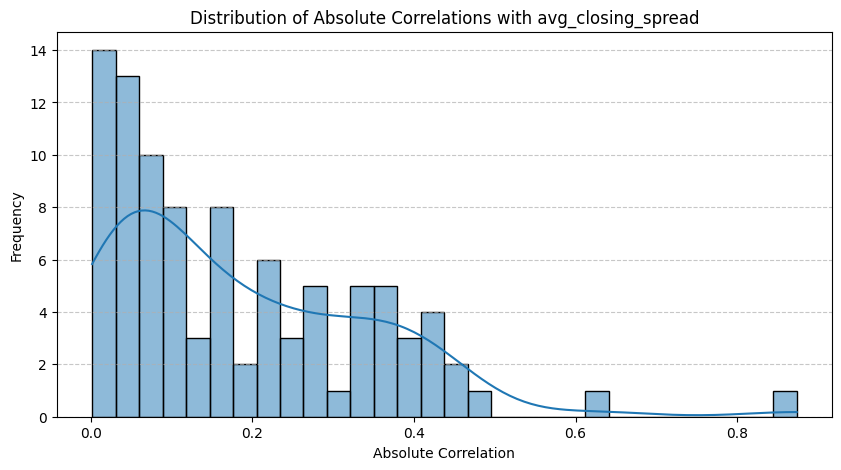

In [30]:
# --- 2a: Feature-Target Correlation ---
print("\n--- Analysis: Feature-Target Correlation ---")
# Combine X_train and y_train temporarily for correlation calculation
train_corr_df = X_train.copy()
train_corr_df[target_variable] = y_train

# Calculate correlations with the target variable
correlations = train_corr_df.corr()[target_variable].drop(target_variable) # Drop self-correlation
correlations_abs = correlations.abs().sort_values(ascending=False)

print(f"Top 20 Features correlated with '{target_variable}' (Absolute Value):")
print(correlations_abs.head(20))
print(f"\nBottom 10 Features correlated with '{target_variable}' (Absolute Value):")
print(correlations_abs.tail(10))

# Plotting the distribution of absolute correlations
plt.figure(figsize=(10, 5))
sns.histplot(correlations_abs, bins=30, kde=True)
plt.title(f'Distribution of Absolute Correlations with {target_variable}')
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [31]:
# --- 2b: Feature-Feature Correlation ---
print("\n--- Analysis: Feature-Feature Correlation ---")
feature_corr_matrix = X_train.corr()

# Find highly correlated pairs
correlation_threshold = 0.9 # Identify pairs with correlation > this value
highly_correlated_pairs = []
cols = feature_corr_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)): # Iterate upper triangle
        corr_value = feature_corr_matrix.iloc[i, j]
        if abs(corr_value) > correlation_threshold:
            pair = (cols[i], cols[j], round(corr_value, 4))
            highly_correlated_pairs.append(pair)

print(f"Found {len(highly_correlated_pairs)} pairs with absolute correlation > {correlation_threshold}")

# Identify which feature in the pair to potentially drop (lower correlation with target)
features_to_consider_dropping_corr = set()
if highly_correlated_pairs:
    print("\nHighly Correlated Pairs (Feature1, Feature2, Correlation):")
    # Sort pairs for consistent display (optional)
    highly_correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    for pair in highly_correlated_pairs[:20]: # Show top 20 pairs
        f1, f2, corr_val = pair
        corr_f1_target = correlations_abs.get(f1, 0) # Get correlation with target
        corr_f2_target = correlations_abs.get(f2, 0)

        # Suggest dropping the one with lower absolute correlation to target
        drop_candidate = f1 if corr_f1_target < corr_f2_target else f2
        keep_candidate = f2 if drop_candidate == f1 else f1
        print(f"  - ('{f1}' [{corr_f1_target:.3f}], '{f2}' [{corr_f2_target:.3f}], {corr_val}) -> Suggest dropping: '{drop_candidate}'")
        features_to_consider_dropping_corr.add(drop_candidate) # Add suggestion to a set

    print(f"\nTotal features suggested for dropping due to high correlation: {len(features_to_consider_dropping_corr)}")
    # print("Candidates for dropping:", list(features_to_consider_dropping_corr)) # Uncomment to see full list


--- Analysis: Feature-Feature Correlation ---
Found 7 pairs with absolute correlation > 0.9

Highly Correlated Pairs (Feature1, Feature2, Correlation):
  - ('matchup_HO_v_AD_successRate_ewma_lag1' [0.102], 'matchup_HO_v_AD_standardDowns_successRate_ewma_lag1' [0.100], 0.9477) -> Suggest dropping: 'matchup_HO_v_AD_standardDowns_successRate_ewma_lag1'
  - ('matchup_AO_v_HD_successRate' [0.186], 'matchup_AO_v_HD_standardDowns_successRate' [0.165], 0.9469) -> Suggest dropping: 'matchup_AO_v_HD_standardDowns_successRate'
  - ('matchup_HO_v_AD_ppa_ewma_lag1' [0.084], 'matchup_HO_v_AD_standardDowns_ppa_ewma_lag1' [0.085], 0.9098) -> Suggest dropping: 'matchup_HO_v_AD_ppa_ewma_lag1'
  - ('away_defense_ppa_ewma_lag1' [0.419], 'away_defense_standardDowns_ppa_ewma_lag1' [0.388], 0.9089) -> Suggest dropping: 'away_defense_standardDowns_ppa_ewma_lag1'
  - ('away_offense_ppa_ewma_lag1' [0.476], 'away_offense_standardDowns_ppa_ewma_lag1' [0.450], 0.9062) -> Suggest dropping: 'away_offense_standardDo

In [32]:
features_to_consider_dropping_corr

{'away_defense_standardDowns_ppa_ewma_lag1',
 'away_offense_standardDowns_ppa_ewma_lag1',
 'home_offense_standardDowns_ppa_ewma_lag1',
 'matchup_AO_v_HD_standardDowns_ppa',
 'matchup_AO_v_HD_standardDowns_successRate',
 'matchup_HO_v_AD_ppa_ewma_lag1',
 'matchup_HO_v_AD_standardDowns_successRate_ewma_lag1'}

### Step 3: Model Based Feature Importance (Initial Run)


--- Analysis: Model-Based Feature Importance (Initial Random Forest) ---
Training initial RandomForestRegressor on 6301 samples and 95 features...

Top 30 Features by RandomForest Importance:
                                              feature  importance
6                                       elo_diff_calc    0.810875
3                                     conference_game    0.017235
5                               away_pregame_elo_calc    0.007058
45    away_offense_passingDowns_successRate_ewma_lag1    0.005650
1                                                week    0.005622
33                         away_offense_ppa_ewma_lag1    0.005059
36    away_offense_rushingPlays_successRate_ewma_lag1    0.004686
42           away_offense_standardDowns_ppa_ewma_lag1    0.004658
0                                              season    0.004436
50    away_defense_rushingPlays_successRate_ewma_lag1    0.004245
4                               home_pregame_elo_calc    0.003319
18    home_offe

<ipython-input-33-025fc4bf9396>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')


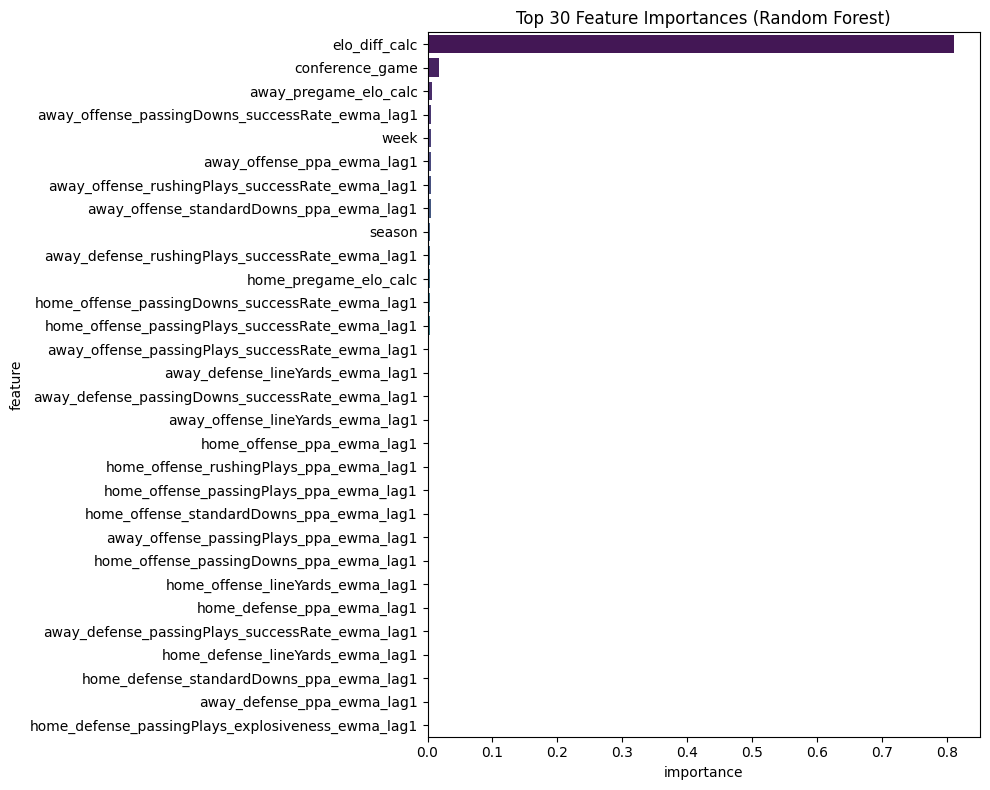


Features remaining after initial filtering & analysis: 95

--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---
Next Steps: Use validation set performance to iteratively select best feature subset based on these analyses.


In [33]:
# We'll just run a quick Random Forest to get an initial importance ranking.
# More rigorous importance analysis and selection happens iteratively later.
print("\n--- Analysis: Model-Based Feature Importance (Initial Random Forest) ---")
from sklearn.ensemble import RandomForestRegressor

# Use a subset of data/trees for speed if necessary, but full training data is better
print(f"Training initial RandomForestRegressor on {X_train.shape[0]} samples and {X_train.shape[1]} features...")
# Instantiate with reasonable defaults (n_jobs=-1 uses all CPU cores)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_leaf=5) # Added some constraints
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 30 Features by RandomForest Importance:")
print(feature_importance_df.head(30))
print("\nBottom 10 Features by RandomForest Importance:")
print(feature_importance_df.tail(10))

# Optional: Plot top N feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')
plt.title('Top 30 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Store the current list of features after initial filtering
features_after_initial_analysis = X_train.columns.tolist()
print(f"\nFeatures remaining after initial filtering & analysis: {len(features_after_initial_analysis)}")

print("\n--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---")
print("Next Steps: Use validation set performance to iteratively select best feature subset based on these analyses.")

## Steps 4,5: Regularization and Iteration

In [34]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings

In [35]:
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

### Define Candidate Feature Sets

In [36]:
candidate_feature_sets = {}

# Set A: Basic Features Only (Baseline)
candidate_feature_sets['A_Basic'] = [f for f in basic_features if f in features_after_initial_analysis]

# Set B: Top N by Absolute Correlation with Target
N_corr = 50 # Example: Top 100
top_corr_features = correlations_abs.head(N_corr).index.tolist()
candidate_feature_sets[f'B_Top{N_corr}_Corr'] = [f for f in top_corr_features if f in features_after_initial_analysis]

# Set C: Top N by Random Forest Importance
N_rf = 50 # Example: Top 100
top_rf_features = feature_importance_df['feature'].head(N_rf).tolist()
candidate_feature_sets[f'C_Top{N_rf}_RF_Importance'] = [f for f in top_rf_features if f in features_after_initial_analysis]

# Set D: Features after removing high inter-feature correlation candidates
# Start with all features after initial filtering
features_after_corr_drop = [f for f in features_after_initial_analysis if f not in features_to_consider_dropping_corr]
candidate_feature_sets['D_Reduced_Correlation'] = features_after_corr_drop

# Set E: All features remaining after initial filtering (Variance/Missing)
candidate_feature_sets['E_All_Initial_Filtered'] = features_after_initial_analysis

# Optional: Combine Top RF + Basic Features
combined_rf_basic = list(set(top_rf_features + candidate_feature_sets['A_Basic']))
candidate_feature_sets[f'F_Top{N_rf}_RF_plus_Basic'] = [f for f in combined_rf_basic if f in features_after_initial_analysis]


print(f"\nDefined {len(candidate_feature_sets)} candidate feature sets:")
for name, features in candidate_feature_sets.items():
    print(f"  - {name}: {len(features)} features")


Defined 6 candidate feature sets:
  - A_Basic: 7 features
  - B_Top50_Corr: 50 features
  - C_Top50_RF_Importance: 50 features
  - D_Reduced_Correlation: 88 features
  - E_All_Initial_Filtered: 95 features
  - F_Top50_RF_plus_Basic: 51 features


### Choose Model for Evaluation: XGBoost

In [37]:
# Define XGBoost parameters (use reasonable defaults or slightly tuned values)
# We are NOT tuning hyperparameters here, just evaluating feature sets
xgb_params = {
    'objective': 'reg:squarederror', # Regression task
    'eval_metric': 'rmse',           # Evaluation metric for XGBoost internal use
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Max tree depth (control complexity)
    'subsample': 0.8,                # Fraction of samples used per tree
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,
    'nthread': -1                    # Use all available CPU threads
    # Enable internal NaN handling if using non-imputed data:
    # 'missing': np.nan # Tells XGBoost to handle NaNs
}
num_boost_round = 100 # Number of boosting rounds (trees)

### Create Betting Model

In [38]:
import math
from tqdm import tqdm

BET_THRESHOLD = 0.5
WIN_PAYOUT = 0.909
LOSS_AMOUNT = 1

def simulate_betting(simulation_input_df):
    """
    Simulates the betting strategy on provided data with predictions.
    Expects 'predicted_spread_market', 'avg_opening_spread', 'home_points',
    'away_points', and other game identifiers.
    Returns a DataFrame with results for each potential bet.
    """
    results = []

    # Ensure necessary columns exist and drop rows with missing critical data for simulation
    required_cols = ['id', 'season', 'week', 'home_team', 'away_team', 'home_points', 'away_points',
                     'avg_opening_spread', 'neutral_site', # neutral_site might not be needed if HFA baked into prediction
                     'predicted_spread_market'] # This comes from the model now
    sim_df = simulation_input_df[required_cols].copy()
    sim_df.dropna(subset=['avg_opening_spread', 'home_points', 'away_points',
                           'predicted_spread_market'], inplace=True) # Crucial dropna

    if sim_df.empty:
        print("Warning: No games available for betting simulation after dropping NaNs.")
        return pd.DataFrame() # Return empty DataFrame

    # print(f"Simulating bets for {len(sim_df)} games...") # Optional debug

    for index, game in sim_df.iterrows():
        predicted_spread = game['predicted_spread_market']
        opening_spread = game['avg_opening_spread']

        bet_on = None
        profit_loss = 0.0
        result = 'no_bet' # Default if threshold not met
        difference = predicted_spread - opening_spread

        # REVISED Trigger Logic
        if abs(difference) > BET_THRESHOLD:
            if predicted_spread > opening_spread:
                bet_on = 'away'
            elif predicted_spread < opening_spread:
                bet_on = 'home'
            # else: difference == 0, no bet

        # Grade the bet if one was placed
        if bet_on:
            # REVISED: Actual margin from AWAY team perspective
            actual_margin = game['away_points'] - game['home_points']

            if bet_on == 'away':
                if actual_margin > opening_spread: result, profit_loss = 'win', WIN_PAYOUT
                elif actual_margin < opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
                else: result, profit_loss = 'push', 0
            elif bet_on == 'home':
                if actual_margin < opening_spread: result, profit_loss = 'win', WIN_PAYOUT
                elif actual_margin > opening_spread: result, profit_loss = 'loss', -LOSS_AMOUNT
                else: result, profit_loss = 'push', 0

        results.append({
            'game_id': game['id'],
            'season': game['season'],
            'predicted_spread_market': predicted_spread,
            'opening_spread': opening_spread,
            'bet_on': bet_on,
            'result': result,
            'profit_loss': profit_loss
        })

    return pd.DataFrame(results)

### Create Evaluation Function

In [39]:
print([f for f in val_df.columns if 'elo' in f])

['home_pregame_elo', 'home_postgame_elo', 'away_pregame_elo', 'away_postgame_elo', 'home_pregame_elo_calc', 'away_pregame_elo_calc', 'elo_diff_calc']


In [40]:
!pip install optuna
# Optional: Integrate betting simulation (requires val_df to have opening spreads & scores)
# Ensure val_df has needed columns if simulating bets:
val_required_cols = ['avg_opening_spread', 'home_points', 'away_points', 'neutral_site', 'id', 'season', 'week', 'home_team', 'away_team', 'home_pregame_elo_calc', 'away_pregame_elo_calc']


def evaluate_feature_set(feature_set_name, features, xgb_params, num_round):
    """Trains XGBoost and evaluates on the validation set."""
    print(f"\n--- Evaluating Feature Set: {feature_set_name} ({len(features)} features) ---")
    start_time = time.time()

    # Select features - using the PRE-IMPUTED data for this loop
    X_train_subset = X_train[features]
    X_val_subset = X_val[features]

    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train_subset, label=y_train)
    dval = xgb.DMatrix(X_val_subset, label=y_val)

    # Train the model
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_round,
        evals=watchlist,
        verbose_eval=False, # Suppress verbose output during training
        # early_stopping_rounds=10 # Optional: Stop early if validation RMSE doesn't improve
    )

    # Predict on validation set
    y_pred_val = model.predict(dval)

    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae = mean_absolute_error(y_val, y_pred_val)
    # Calculate correlation using pandas Series for correct handling
    predictions_series = pd.Series(y_pred_val, index=y_val.index)
    correlation = y_val.corr(predictions_series)
    bias = np.mean(y_pred_val - y_val)

    # --- Optional: Betting Simulation ---
    betting_units = np.nan # Placeholder
    betting_roi = np.nan
    betting_win_rate = np.nan
    # Uncomment and adapt if you have the simulator and necessary columns in val_df
    try:
      # Create a temporary df with predictions and necessary info for sim
      sim_input_df = val_df[val_required_cols].copy()
      sim_input_df['predicted_spread_market'] = y_pred_val
      #Note: The simulator needs the ELO_SPREAD_DIVISOR and HFA from Elo tuning
      #Pass them appropriately if needed by the simulator function
      betting_results = simulate_betting(sim_input_df) # Need elo params
      betting_units = betting_results['profit_loss'].sum()
      total_bets = len(betting_results[betting_results['bet_on'].notna()])
      total_wins = len(betting_results[betting_results['result'] == 'win'])
      total_losses = len(betting_results[betting_results['result'] == 'loss'])
      if (total_wins + total_losses) > 0:
          betting_win_rate = total_wins / (total_wins + total_losses)
      total_risked = (total_wins + total_losses)  # LOSS_AMOUNT=1
      if total_risked > 0:
          betting_roi = (betting_units / total_risked) * 100
    except Exception as e:
      print(f"Betting simulation failed for {feature_set_name}: {e}")
    # ------------------------------------

    end_time = time.time()
    duration = end_time - start_time

    results = {
        'Set Name': feature_set_name,
        'Num Features': len(features),
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation,
        'Bias': bias,
        'Betting Units': betting_units, # Will be NaN if simulation skipped
        'Betting Win Rate': betting_win_rate, # Will be NaN if simulation skipped
        'Betting ROI': betting_roi, # Will be NaN if simulation skipped
        'Eval Time (s)': duration
    }

    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Correlation: {correlation:.4f}, Bias: {bias:.4f}, Time: {duration:.1f}s")
    # print(f"  Betting: Units={betting_units:.2f}, Win Rate={betting_win_rate:.2%}, ROI={betting_roi:.2f}%") # Uncomment if sim runs

    return results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.6 MB/s eta 0:00:00


### Run the Loop

In [41]:
all_results = []
for name, feature_list in candidate_feature_sets.items():
    # Ensure feature list is not empty and features exist in X_train
    valid_features = [f for f in feature_list if f in X_train.columns]
    if not valid_features:
        print(f"\n--- Skipping Feature Set: {name} (No valid features found) ---")
        continue
    if len(valid_features) < len(feature_list):
         print(f"\nWarning: Some features for set '{name}' were not found in X_train after filtering.")

    result = evaluate_feature_set(name, valid_features, xgb_params, num_boost_round)
    all_results.append(result)


--- Evaluating Feature Set: A_Basic (7 features) ---
  RMSE: 6.5744, MAE: 5.0072, Correlation: 0.9160, Bias: 0.4091, Time: 2.6s

--- Evaluating Feature Set: B_Top50_Corr (50 features) ---
  RMSE: 5.9976, MAE: 4.5995, Correlation: 0.9313, Bias: -0.4715, Time: 7.4s

--- Evaluating Feature Set: C_Top50_RF_Importance (50 features) ---
  RMSE: 5.9555, MAE: 4.5486, Correlation: 0.9315, Bias: 0.1647, Time: 4.5s

--- Evaluating Feature Set: D_Reduced_Correlation (88 features) ---
  RMSE: 5.8591, MAE: 4.4805, Correlation: 0.9337, Bias: 0.1133, Time: 1.5s

--- Evaluating Feature Set: E_All_Initial_Filtered (95 features) ---
  RMSE: 5.9372, MAE: 4.5299, Correlation: 0.9320, Bias: 0.2529, Time: 3.8s

--- Evaluating Feature Set: F_Top50_RF_plus_Basic (51 features) ---
  RMSE: 6.0019, MAE: 4.5551, Correlation: 0.9306, Bias: 0.2248, Time: 0.9s


### Present Results

In [42]:
print("\n--- Feature Set Evaluation Summary ---")
results_df = pd.DataFrame(all_results)
results_df.sort_values(by='RMSE', ascending=True, inplace=True) # Sort by primary metric (RMSE)

# Format columns for display
results_df['RMSE'] = results_df['RMSE'].map('{:.4f}'.format)
results_df['MAE'] = results_df['MAE'].map('{:.4f}'.format)
results_df['Correlation'] = results_df['Correlation'].map('{:.4f}'.format)
results_df['Bias'] = results_df['Bias'].map('{:.4f}'.format)
results_df['Betting Units'] = results_df['Betting Units'].map('{:.2f}'.format)
results_df['Betting Win Rate'] = results_df['Betting Win Rate'].map('{:.2%}'.format)
results_df['Betting ROI'] = results_df['Betting ROI'].map('{:.2f}%'.format)
results_df['Eval Time (s)'] = results_df['Eval Time (s)'].map('{:.1f}'.format)


print(results_df.to_string(index=False))

print("\n--- Phase 2, Steps 4 & 5 Complete ---")
print("Evaluated candidate feature sets on the validation data.")
print("Next Steps: Analyze results, potentially refine feature sets and iterate, then proceed to hyperparameter tuning (Phase 3) on the chosen set(s).")


--- Feature Set Evaluation Summary ---
              Set Name  Num Features   RMSE    MAE Correlation    Bias Betting Units Betting Win Rate Betting ROI Eval Time (s)
 D_Reduced_Correlation            88 5.8591 4.4805      0.9337  0.1133        -34.16           51.16%      -2.33%           1.5
E_All_Initial_Filtered            95 5.9372 4.5299      0.9320  0.2529        -51.89           50.52%      -3.57%           3.8
 C_Top50_RF_Importance            50 5.9555 4.5486      0.9315  0.1647        -24.43           51.51%      -1.67%           4.5
          B_Top50_Corr            50 5.9976 4.5995      0.9313 -0.4715        -48.61           50.65%      -3.31%           7.4
 F_Top50_RF_plus_Basic            51 6.0019 4.5551      0.9306  0.2248        -23.43           51.54%      -1.61%           0.9
               A_Basic             7 6.5744 5.0072      0.9160  0.4091        -78.25           49.59%      -5.33%           2.6

--- Phase 2, Steps 4 & 5 Complete ---
Evaluated candidate featu

# Phase 3: Model Selection and Training

### Select Best Feature Set

In [43]:
# Choose the set name that performed best in the previous step's results_df
# Example: Assuming 'D_Reduced_Correlation' was best
# best_feature_set_name = 'D_Reduced_Correlation'
# If you manually created the list previously:
# best_features = features_after_corr_drop # Or whichever list corresponds to the best set
# Or retrieve from the candidate dictionary:
best_feature_set_name = results_df.iloc[0]['Set Name'] # Assumes results_df sorted by best metric
best_features = candidate_feature_sets[best_feature_set_name]

print(f"Selected best feature set for tuning: '{best_feature_set_name}' ({len(best_features)} features)")

# Prepare final training and validation data with ONLY the selected features
# Using the temporarily imputed data from the previous step for consistency during tuning
X_train_best = X_train[best_features].copy()
X_val_best = X_val[best_features].copy()

print(f"Using feature shapes: X_train_best={X_train_best.shape}, X_val_best={X_val_best.shape}")

Selected best feature set for tuning: 'D_Reduced_Correlation' (88 features)
Using feature shapes: X_train_best=(6301, 88), X_val_best=(1699, 88)


### Define Objective Function for Optuna

In [55]:
import optuna

def objective_xgb(trial, X_train_hp, y_train_hp, X_val_hp, y_val_hp, validation_df_hp):
    """Objective function for Optuna XGBoost hyperparameter tuning."""

    # --- 3. Define Search Space ---
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'nthread': -1, # Use all cores
        'tree_method': 'gpu_hist', # Enable GPU Acceleration
        # Parameters to tune:
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),             # Learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 9),                  # Max tree depth
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),            # Row subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Feature subsampling
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),   # Min samples in leaf node
        'gamma': trial.suggest_float('gamma', 0, 0.5),                      # Min loss reduction for split
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),       # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),         # L1 regularization
        # 'missing': np.nan # Enable if using non-imputed data
    }

    # Fixed number of boosting rounds for tuning (can be tuned itself later)
    # Or use early stopping within the training call
    num_boost_round_hp = 200 # Increase rounds for tuning?

    # Prepare data
    dtrain = xgb.DMatrix(X_train_hp, label=y_train_hp)
    dval = xgb.DMatrix(X_val_hp, label=y_val_hp)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    # Train model with suggested parameters
    # Using early stopping is highly recommended during tuning
    bst = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round_hp,
        evals=watchlist,
        early_stopping_rounds=25, # Stop if validation RMSE doesn't improve for 25 rounds
        verbose_eval=False # Keep quiet during Optuna trials
    )

    # Evaluate on validation set
    y_pred_val_hp = bst.predict(dval, iteration_range=(0, bst.best_iteration)) # Use best iteration
    rmse_val = np.sqrt(mean_squared_error(y_val_hp, y_pred_val_hp))

    # --- Optional: Calculate betting simulation for this trial ---
    # This adds significant time to each trial but directly optimizes for bets

    run_betting_sim_in_tuning = False # Set to False to speed up tuning based only on RMSE

    if run_betting_sim_in_tuning:
        try:
            sim_input_df_hp = validation_df_hp[val_required_cols].copy()
            sim_input_df_hp['predicted_spread_market'] = pd.Series(y_pred_val_hp, index=validation_df_hp.index) # Align index
            betting_results_hp = simulate_betting(sim_input_df_hp)

            if not betting_results_hp.empty:
                betting_units_hp = betting_results_hp['profit_loss'].sum()
                bets_placed_df_hp = betting_results_hp[betting_results_hp['bet_on'].notna()]
                wins_hp = len(bets_placed_df_hp[bets_placed_df_hp['result'] == 'win'])
                losses_hp = len(bets_placed_df_hp[bets_placed_df_hp['result'] == 'loss'])
                if (wins_hp + losses_hp) > 0:
                    total_risked_hp = (wins_hp + losses_hp) * LOSS_AMOUNT
                    roi_hp = (betting_units_hp / total_risked_hp) * 100 if total_risked_hp > 0 else 0.0
                else:
                     roi_hp = 0.0 # Or NaN
                 # Store ROI as user attribute to see it, but still optimize RMSE
                trial.set_user_attr("val_roi", roi_hp)
                trial.set_user_attr("val_units", betting_units_hp)
            else:
                 trial.set_user_attr("val_roi", np.nan)
                 trial.set_user_attr("val_units", 0.0)

        except Exception as e:
             print(f"Warning: Betting sim failed in trial {trial.number}: {e}")
             trial.set_user_attr("val_roi", np.nan)
             trial.set_user_attr("val_units", np.nan)

    # Return the metric to minimize (Validation RMSE)
    return rmse_val

### Run Optuna Study

In [56]:
N_TRIALS_HP = 100 # Number of hyperparameter combinations to test (adjust as needed)

print(f"\nStarting Optuna hyperparameter search ({N_TRIALS_HP} trials)...")
study_hp = optuna.create_study(direction='minimize', study_name='XGBoost Spread Prediction') # Minimize RMSE

# Pass necessary dataframes via lambda function
study_hp.optimize(
    lambda trial: objective_xgb(trial, X_train_best, y_train, X_val_best, y_val, val_df),
    n_trials=N_TRIALS_HP,
    show_progress_bar=True
)

[I 2025-04-09 17:35:08,092] A new study created in memory with name: XGBoost Spread Prediction



Starting Optuna hyperparameter search (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-04-09 17:35:08,917] Trial 0 finished with value: 6.705117414320208 and parameters: {'eta': 0.01135654089658209, 'max_depth': 3, 'subsample': 0.985565932773578, 'colsample_bytree': 0.8897305848956849, 'min_child_weight': 7, 'gamma': 0.3842286918331424, 'lambda': 1.0664843227311758e-05, 'alpha': 7.400380928794464e-05}. Best is trial 0 with value: 6.705117414320208.
[I 2025-04-09 17:35:09,722] Trial 1 finished with value: 5.876170690761676 and parameters: {'eta': 0.031081970753467875, 'max_depth': 4, 'subsample': 0.7551160878265265, 'colsample_bytree': 0.5384645236995591, 'min_child_weight': 6, 'gamma': 0.2817673032668313, 'lambda': 4.983317375967279e-07, 'alpha': 3.656082438425162e-06}. Best is trial 1 with value: 5.876170690761676.
[I 2025-04-09 17:35:10,317] Trial 2 finished with value: 5.94682897706931 and parameters: {'eta': 0.024866708321576864, 'max_depth': 4, 'subsample': 0.8852159576022613, 'colsample_bytree': 0.8987257093527775, 'min_child_weight': 6, 'gamma': 0.10322348

### Identify Best Hyperparameters

In [57]:
print("\nOptimization Finished.")
print(f"Number of finished trials: {len(study_hp.trials)}")
print(f"Best trial (Validation RMSE): {study_hp.best_value:.4f}")

print("Best hyperparameters:")
best_xgb_params = study_hp.best_params
for key, value in best_xgb_params.items():
    print(f"  {key}: {value}")

# --- Optional: Show best trial's betting performance ---
best_trial_info = study_hp.best_trial
if 'val_roi' in best_trial_info.user_attrs:
    print(f"\nBest Trial's Validation Betting Performance:")
    print(f"  Units: {best_trial_info.user_attrs.get('val_units', 'N/A'):.2f}")
    print(f"  ROI:   {best_trial_info.user_attrs.get('val_roi', 'N/A'):.2f}%")


# --- Retrain Final Model with Best Parameters (Optional here, usually done before Test Set) ---
# You would typically save these `best_xgb_params` and use them to train a final model
# on the *combined* training + validation data before predicting on the test set.
# For now, we have identified the best settings based on validation performance.

print("\n--- Phase 3 (Hyperparameter Tuning) Complete ---")
print("Identified best XGBoost hyperparameters based on validation set performance.")
print("Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.")


Optimization Finished.
Number of finished trials: 100
Best trial (Validation RMSE): 5.7728
Best hyperparameters:
  eta: 0.04839373390852491
  max_depth: 6
  subsample: 0.6345047814321023
  colsample_bytree: 0.7414773028589341
  min_child_weight: 8
  gamma: 0.44415336114682846
  lambda: 0.0029796639927556308
  alpha: 5.035568036853241e-07

--- Phase 3 (Hyperparameter Tuning) Complete ---
Identified best XGBoost hyperparameters based on validation set performance.
Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.


# Phase 4 Final Evaluation

### Define Train+Validation and Test Sets

In [58]:
TEST_START_SEASON = VALIDATION_END_SEASON + 1

print(f"Using final split points:")
print(f"  Train+Validation: Seasons <= {VALIDATION_END_SEASON}")
print(f"  Test:             Seasons >= {TEST_START_SEASON}")

train_val_df = master_df[master_df['season'] <= VALIDATION_END_SEASON].copy()
test_df = master_df[master_df['season'] >= TEST_START_SEASON].copy()

print(f"\nData Shapes:")
print(f"  Train+Validation Set: {train_val_df.shape}")
print(f"  Test Set:             {test_df.shape}")

if test_df.empty:
    print("\nERROR: Test set is empty. Cannot perform final evaluation.")
    # Exit or handle appropriately
    exit()


Using final split points:
  Train+Validation: Seasons <= 2022
  Test:             Seasons >= 2023

Data Shapes:
  Train+Validation Set: (8000, 245)
  Test Set:             (1723, 245)


### Prepare Data for Final Model

In [59]:
# Select the best features identified earlier
X_train_val = train_val_df[best_features].copy()
y_train_val = train_val_df[target_variable]

X_test = test_df[best_features].copy()
y_test = test_df[target_variable]

print(f"\nFeature matrix shapes for final model:")
print(f"  X_train_val: {X_train_val.shape}")
print(f"  X_test:      {X_test.shape}")

# --- Handle Missing Values (Strategy Decision) ---
# IMPORTANT: Use the SAME strategy as during hyperparameter tuning.
# If XGBoost's internal NaN handling was used (recommended), do nothing here.
# If imputation was done (e.g., median), apply it here using values
# calculated ONLY from the original *training* set (train_df).

# Assuming XGBoost internal NaN handling (if tree_method='gpu_hist' was used):
print("\nAssuming XGBoost will handle NaNs internally (no imputation applied).")
# If you need to impute (e.g., using training median):
# features_with_nan_final = X_train_val.columns[X_train_val.isnull().any()].tolist()
# # Calculate median ONLY from original training data (train_df must exist)
# imputation_values_final = train_df[features_with_nan_final].median()
# print(f"Applying median imputation based on original training data to {len(features_with_nan_final)} columns...")
# X_train_val.fillna(imputation_values_final, inplace=True)
# X_test.fillna(imputation_values_final, inplace=True)
# print(f"NaN check after imputation (X_train_val): {X_train_val.isnull().sum().sum()}")
# print(f"NaN check after imputation (X_test):      {X_test.isnull().sum().sum()}")

# Prepare data for XGBoost
print("Preparing DMatrix for XGBoost...")
dtrain_val = xgb.DMatrix(X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test, label=y_test)



Feature matrix shapes for final model:
  X_train_val: (8000, 88)
  X_test:      (1723, 88)

Assuming XGBoost will handle NaNs internally (no imputation applied).
Preparing DMatrix for XGBoost...


### Train Final XGBoost Model

In [60]:
# Combine base parameters with the best ones found by Optuna
final_xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    'nthread': -1,
    # Add 'tree_method': 'gpu_hist' IF you are using a GPU runtime for this final training
    'tree_method': 'gpu_hist'
}
final_xgb_params.update(best_xgb_params) # Add tuned parameters

# Determine the number of boosting rounds
# Option 1: Use a fixed number (e.g., the one used in tuning or slightly more)
# num_boost_round_final = 200 # Example
# Option 2: If you logged bst.best_iteration from the best Optuna trial, use that.
# best_iteration = ??? # Need to retrieve this value from tuning results if possible
# Option 3: Train with early stopping against a small validation split *of the train_val_df*
# This is safer but adds complexity. Let's use a fixed number for now.
num_boost_round_final = 200 # Use the value determined during tuning or a reasonable default
print(f"Training final XGBoost model with {len(best_features)} features for {num_boost_round_final} rounds...")
print("Using hyperparameters:", final_xgb_params)

start_train_time = time.time()
final_model = xgb.train(
    final_xgb_params,
    dtrain_val,
    num_boost_round=num_boost_round_final,
    evals=[(dtrain_val, 'train'), (dtest, 'test')], # Monitor performance on test set during training
    verbose_eval=50 # Print progress every 50 rounds
)
end_train_time = time.time()
print(f"Final model training finished in {end_train_time - start_train_time:.2f} seconds.")

Training final XGBoost model with 88 features for 200 rounds...
Using hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': -1, 'tree_method': 'gpu_hist', 'eta': 0.04839373390852491, 'max_depth': 6, 'subsample': 0.6345047814321023, 'colsample_bytree': 0.7414773028589341, 'min_child_weight': 8, 'gamma': 0.44415336114682846, 'lambda': 0.0029796639927556308, 'alpha': 5.035568036853241e-07}
[0]	train-rmse:15.64807	test-rmse:15.01726
[50]	train-rmse:5.76474	test-rmse:5.94804
[100]	train-rmse:4.93746	test-rmse:5.83628
[150]	train-rmse:4.49917	test-rmse:5.84941
[199]	train-rmse:4.16987	test-rmse:5.86142
Final model training finished in 1.00 seconds.


### Predict on Test Set

In [61]:
print("\nPredicting on Test Set...")
y_pred_test = final_model.predict(dtest)
predictions_test_series = pd.Series(y_pred_test, index=y_test.index)


Predicting on Test Set...


### Evaluate Statistical Metrics on Test Set

In [62]:
print("\n--- Test Set Statistical Performance ---")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
correlation_test = y_test.corr(predictions_test_series)
bias_test = np.mean(y_pred_test - y_test)
r2_test = r2_score(y_test, y_pred_test) # R-squared

print(f"  RMSE:        {rmse_test:.4f}")
print(f"  MAE:         {mae_test:.4f}")
print(f"  Correlation: {correlation_test:.4f}")
print(f"  Bias:        {bias_test:.4f}")
print(f"  R-squared:   {r2_test:.4f}")


--- Test Set Statistical Performance ---
  RMSE:        5.8614
  MAE:         4.4467
  Correlation: 0.9280
  Bias:        -0.1480
  R-squared:   0.8600


### Plot Predictions vs. Actuals for Test Set

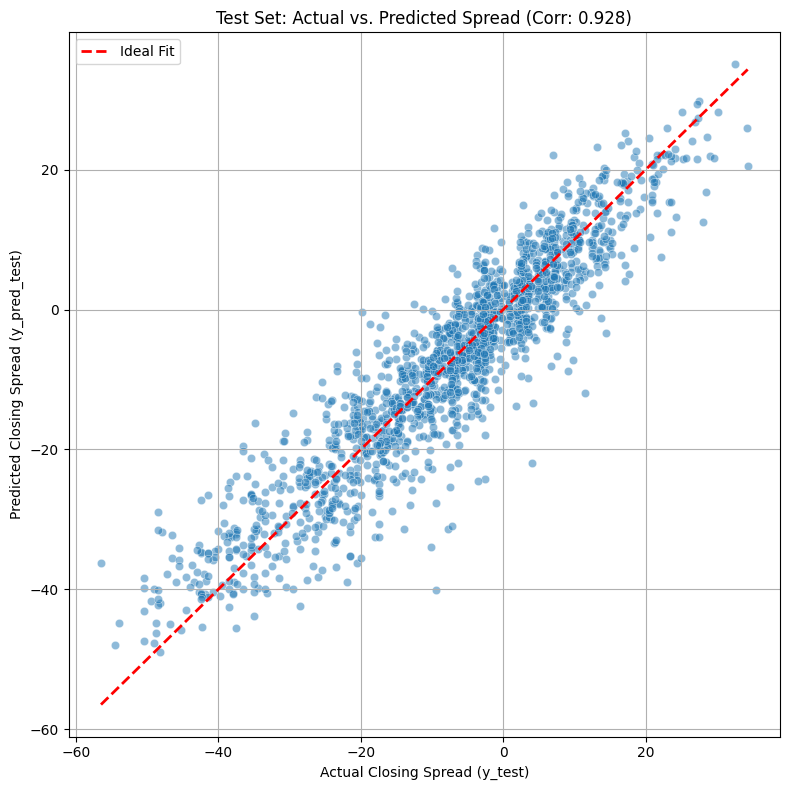

In [63]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal Fit')
plt.xlabel("Actual Closing Spread (y_test)")
plt.ylabel("Predicted Closing Spread (y_pred_test)")
plt.title(f"Test Set: Actual vs. Predicted Spread (Corr: {correlation_test:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate Betting Performance on Test Set

In [64]:
print("\n--- Test Set Betting Performance ---")

# Prepare input for the simulator
# Select necessary columns from the original test_df
sim_input_test_df = test_df[val_required_cols].copy()
# Add the predictions, ensuring index alignment
sim_input_test_df['predicted_spread_market'] = predictions_test_series

# Run the simulation
test_betting_results = simulate_betting(sim_input_test_df)

if test_betting_results.empty:
    print("No bets were placed on the test set according to the strategy.")
else:
    # Aggregate results
    test_total_units = test_betting_results['profit_loss'].sum()
    test_bets_placed_df = test_betting_results[test_betting_results['bet_on'].notna()]
    test_total_bets = len(test_bets_placed_df)
    test_wins = len(test_bets_placed_df[test_bets_placed_df['result'] == 'win'])
    test_losses = len(test_bets_placed_df[test_bets_placed_df['result'] == 'loss'])
    test_pushes = len(test_bets_placed_df[test_bets_placed_df['result'] == 'push'])

    test_win_rate = test_wins / (test_wins + test_losses) if (test_wins + test_losses) > 0 else np.nan
    test_total_risked = (test_wins + test_losses) * LOSS_AMOUNT
    test_roi = (test_total_units / test_total_risked) * 100 if test_total_risked > 0 else 0.0

    print(f"  Total Bets:   {test_total_bets}")
    print(f"  Wins:         {test_wins}")
    print(f"  Losses:       {test_losses}")
    print(f"  Pushes:       {test_pushes}")
    print(f"  Win Rate:     {test_win_rate:.2%}")
    print(f"  Total Units:  {test_total_units:+.2f}")
    print(f"  ROI:          {test_roi:.2f}%")


--- Test Set Betting Performance ---
  Total Bets:   1484
  Wins:         749
  Losses:       726
  Pushes:       9
  Win Rate:     50.78%
  Total Units:  -45.16
  ROI:          -3.06%


### Plot Cumulative Units over Time

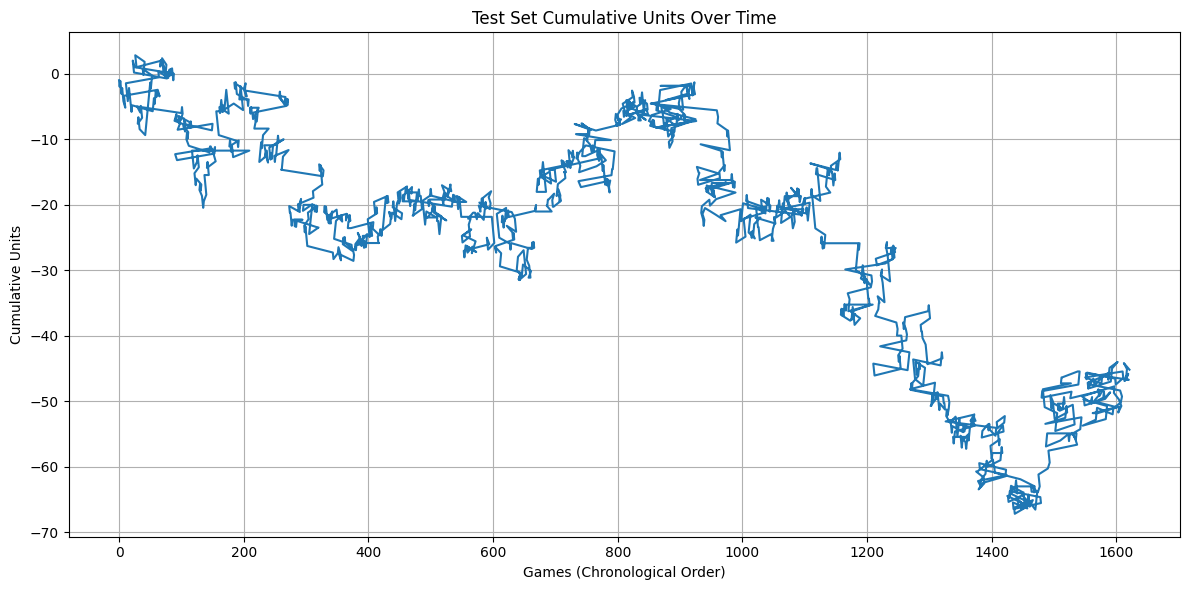

In [66]:
# Optional: Plot cumulative units over time for the test set
test_betting_results = pd.merge(test_betting_results[['game_id', 'profit_loss']],
                                test_df[['id', 'season', 'week']],
                                left_on='game_id', right_on='id')
test_betting_results['game_date_order'] = test_betting_results['season'] * 100 + test_betting_results['week']
test_betting_results.sort_values('game_date_order', inplace=True)
test_betting_results['cumulative_units'] = test_betting_results['profit_loss'].cumsum()

plt.figure(figsize=(12, 6))
test_betting_results['cumulative_units'].plot()
plt.title('Test Set Cumulative Units Over Time')
plt.xlabel('Games (Chronological Order)')
plt.ylabel('Cumulative Units')
plt.grid(True)
plt.tight_layout()
plt.show()